# Section 1. Project Information

| Items | Description |
|----------|----------|
| Project Name   | class 8 US net orders prediction model |
| Developer | Xinyu Li   |
| Google Drive Link |Project Location: https://drive.google.com/drive/folders/1VmnPMJu9nDSzxPllew2BVqN7sbTX7vzZ?usp=drive_link|
| Goal | At the end of year, the model will be used to predict the monthly sales for each month of the next year |

# Section 2. Load Library

In [278]:
%reset -f

In [489]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_validate
from xgboost import XGBRegressor
from IPython.display import Image

# Section 3. Import Dataset
- There is a lack of consistency of date in Economic_Freight_Variables data set
    - Ex: '2019-01-19', '2019-02-19', '2020-01-19', '2020-02-19'
    - Those values will be replaced with the first date in that month.

In [280]:
US_Class_8_Net_Orders = pd.read_excel('Sales data.xlsx', sheet_name = 'US Class 8 Net Orders').drop(columns='Country')
US_Class_8_Net_Orders['Date'] = pd.to_datetime(US_Class_8_Net_Orders['Date'])
Economic_Freight_Variables = pd.read_excel('Sales data.xlsx', sheet_name = 'Economic & Freight Variables', header=0, skiprows=[1, 2]).rename(columns={'Title:': 'Date'})
Economic_Freight_Variables['Date'] = pd.to_datetime(Economic_Freight_Variables['Date'])
Economic_Freight_Variables['Date'] = Economic_Freight_Variables['Date'].replace(pd.to_datetime('2019-01-19'), pd.to_datetime('2019-01-01'))
Economic_Freight_Variables['Date'] = Economic_Freight_Variables['Date'].replace(pd.to_datetime('2019-02-19'), pd.to_datetime('2019-02-01'))
Economic_Freight_Variables['Date'] = Economic_Freight_Variables['Date'].replace(pd.to_datetime('2020-01-19'), pd.to_datetime('2020-01-01'))
Economic_Freight_Variables['Date'] = Economic_Freight_Variables['Date'].replace(pd.to_datetime('2020-02-19'), pd.to_datetime('2020-02-01'))
df = pd.merge(US_Class_8_Net_Orders, Economic_Freight_Variables)
df.head()

Date  Units  Real Personal Consumption Expenditures  \
0 2000-01-01  14364                                  7988.5   
1 2000-02-01  12192                                  8065.3   
2 2000-03-01   9359                                  8110.8   
3 2000-04-01  10460                                  8101.6   
4 2000-05-01   7191                                  8139.0   

   Real PCE: Durable Goods  Real PCE: Nondurable Goods  Real PCE: Services  \
0                    750.2                      1807.3              5476.5   
1                    770.5                      1820.9              5512.4   
2                    763.0                      1848.9              5543.5   
3                    745.3                      1857.2              5552.5   
4                    750.5                      1865.1              5576.1   

   Capacity Utilization: Total Industry  \
0                               82.0528   
1                               82.0733   
2                               82.1053   
3                               82.3387   
4                               82.3055   

   Commercial and Industrial Loans, Commercial Banks, SA  \
0                                          1003.6370       
1                                          1016.6491       
2                                          1026.2262       
3                                          1035.1754       
4                                          1052.0214       

   Industrial Production Index  Industrial Production Index - Mfg.  \
0                      91.6261                             92.2764   
1                      91.9626                             92.5669   
2                      92.3118                             93.1949   
3                      92.8872                             93.8051   
4                      93.1620                             93.8815   

   Inventories: Total Business  Inventory to Sales Ratio: Total Business  \
0                      1140023                                      1.38   
1                      1146435                                      1.40   
2                      1150666                                      1.38   
3                      1157552                                      1.39   
4                      1163974                                      1.40   

   ISM INDEX: PMI Manufacturing Composite Index  ISM INDEX Backlogs  \
0                                          56.7                52.0   
1                                          55.8                54.0   
2                                          54.9                51.0   
3                                          54.7                51.0   
4                                          53.2                49.0   

   ISM INDEX Customer Inventories  ISM INDEX Employment   ISM INDEX Exports  \
0                            46.5                   52.8               53.4   
1                            48.0                   53.6               54.2   
2                            48.0                   51.2               54.8   
3                            47.0                   53.2               51.5   
4                            50.5                   53.0               56.4   

   ISM INDEX Imports  ISM INDEX Inventories  ISM INDEX New Orders  \
0               52.9                   52.8                  60.4   
1               53.0                   44.9                  58.7   
2               53.5                   47.5                  56.2   
3               53.8                   46.1                  55.4   
4               54.2                   46.9                  51.5   

   ISM INDEX Prices  ISM INDEX Production  ISM INDEX Supplier deliveries  \
0              72.4                  57.8                           55.0   
1              71.6                  59.1                           54.4   
2              78.7                  59.5                           54.3   
3              71.2                  58.1

# Section 4. Descriptive Statistical Analysis
- The original data set is composed of continuous variables and one datetime object variable - 'Date'. There is no categorical variable.
- There are two variables within the dataset containing null values:
    - PPI: Finished Goods Less Food & Energy
    - PPI Finished Goods: Capital Equipment 
    

## Part 1. Non-Null Count & Data Type

In [281]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 102 columns):
 #    Column                                                      Non-Null Count  Dtype         
---   ------                                                      --------------  -----         
 0    Date                                                        264 non-null    datetime64[ns]
 1    Units                                                       264 non-null    int64         
 2    Real Personal Consumption Expenditures                      264 non-null    float64       
 3    Real PCE: Durable Goods                                     264 non-null    float64       
 4    Real PCE: Nondurable Goods                                  264 non-null    float64       
 5    Real PCE: Services                                          264 non-null    float64       
 6    Capacity Utilization: Total Industry                        264 non-null    float64       
 7    Commercial and 

## Part 2. Descriptive Statistics

In [282]:
df.describe()

Units  Real Personal Consumption Expenditures  \
count    264.000000                              264.000000   
mean   16682.390152                            10966.844318   
std     8914.953383                             1466.828777   
min     3678.000000                             7988.500000   
25%    10020.000000                            10126.100000   
50%    14580.500000                            10850.600000   
75%    20913.250000                            12135.450000   
max    49208.000000                            13891.000000   

       Real PCE: Durable Goods  Real PCE: Nondurable Goods  \
count               264.000000                  264.000000   
mean               1232.743561                 2540.642045   
std                 383.107461                  352.198799   
min                 745.300000                 1807.300000   
25%                 971.050000                 2381.125000   
50%                1089.500000                 2491.500000   
75%                1461.450000                 2761.075000   
max                2433.600000                 3431.800000   

       Real PCE: Services  Capacity Utilization: Total Industry  \
count          264.000000                            264.000000   
mean          7224.843939                             76.952005   
std            801.649421                              3.205705   
min           5476.500000                             64.529800   
25%           6726.100000                             75.397250   
50%           7274.100000                             77.111550   
75%           7893.075000                             79.196200   
max           8550.400000                             82.338700   

       Commercial and Industrial Loans, Commercial Banks, SA  \
count                                         264.000000       
mean                                         1546.243856       
std                                           544.840141       
min                                           862.840900       
25%                                          1072.732800       
50%                                          1415.669550       
75%                                          2050.738475       
max                                          3025.189700       

       Industrial Production Index  Industrial Production Index - Mfg.  \
count                   264.000000                          264.000000   
mean                     96.596012                           96.992890   
std                       4.867979                            4.884225   
min                      84.727700                           80.395200   
25%                      92.614700                           93.499525   
50%                      97.947800                           98.588400   
75%                     100.699875                          100.238400   
max                     104.180200                          106.473700   

       Inventories: Total Business  Inventory to Sales Ratio: Total Business  \
count                 2.640000e+02                                264.000000   
mean                  1.560768e+06                                  1.339773   
std                   3.136070e+05                                  0.069117   
min                   1.106806e+06                                  1.240000   
25%                   1.275658e+06                                  1.280000   
50%                   1.519142e+06                                  1.320000   
75%                   1.838052e+06                                  1.400000   
max                   2.197539e+06                                  1.740000   

       ISM INDEX: PMI Manufacturing Composite Index  ISM INDEX Backlogs  \
count                                    264.000000          264.000000   
mean                                      52.938258           50.220833   
std                                        5.314627            7.387224   
min               

# Section 5. Data Preprocessing - Handling Missing Values / Shifting Dataset / Remove Outliers

## Part 1. Handling Missing Values

- Overview of Columns with Missing Values

In [283]:
for column in df.columns:
    if df[column].isnull().sum() != 0:
        print('name:', column)
        print('null value counts:', df[column].isnull().sum())
        print('null value percentage:', round(df[column].isnull().sum()/len(df),2))
        print()

name: Savings Deposits - Total
null value counts: 20
null value percentage: 0.08

name: PPI: Finished Goods Less Food & Energy
null value counts: 72
null value percentage: 0.27

name: PPI Finished Goods: Capital Equipment
null value counts: 72
null value percentage: 0.27



- Distribution of columns over time

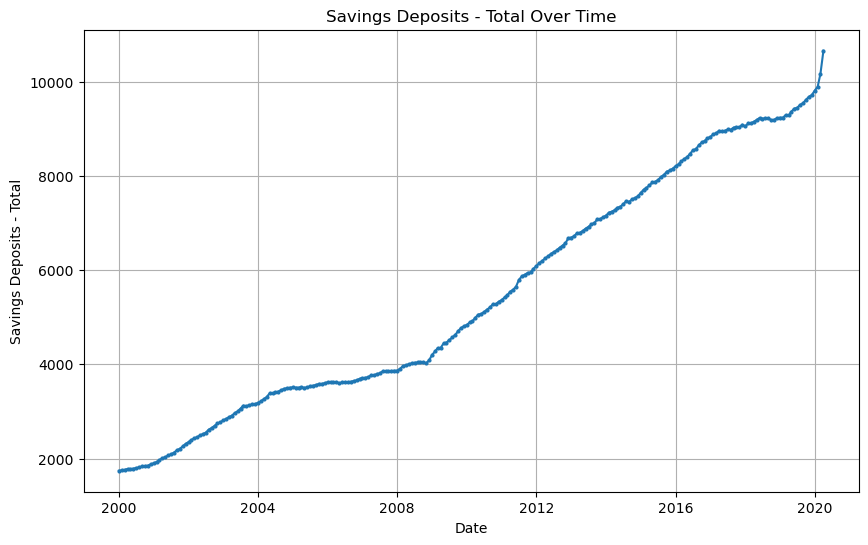

In [284]:
#distribution of Savings Deposits - Total
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Savings Deposits - Total'], marker='o', linestyle='-', markersize=2)
plt.title('Savings Deposits - Total Over Time')
plt.xlabel('Date')
plt.ylabel('Savings Deposits - Total')
plt.grid(True)
plt.show()

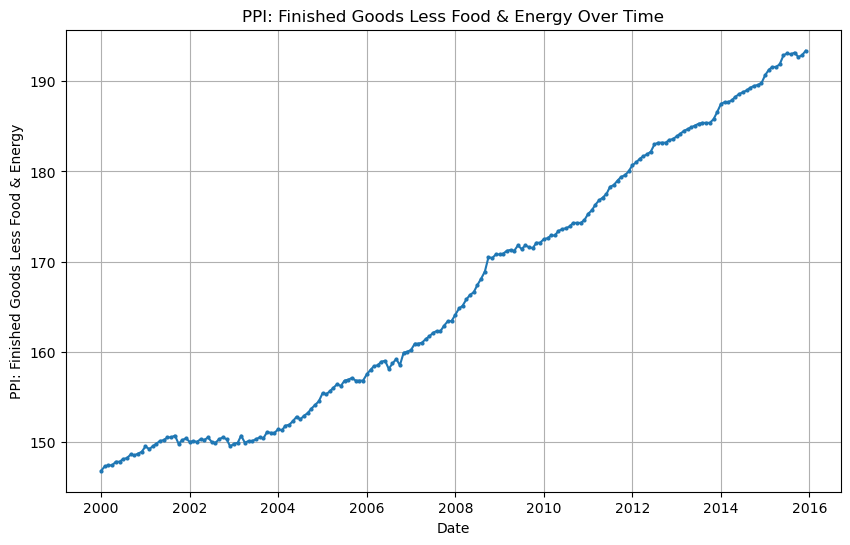

In [285]:
#distribution of PPI: Finished Goods Less Food & Energy
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['PPI: Finished Goods Less Food & Energy'], marker='o', linestyle='-', markersize=2)
plt.title('PPI: Finished Goods Less Food & Energy Over Time')
plt.xlabel('Date')
plt.ylabel('PPI: Finished Goods Less Food & Energy')
plt.grid(True)
plt.show()

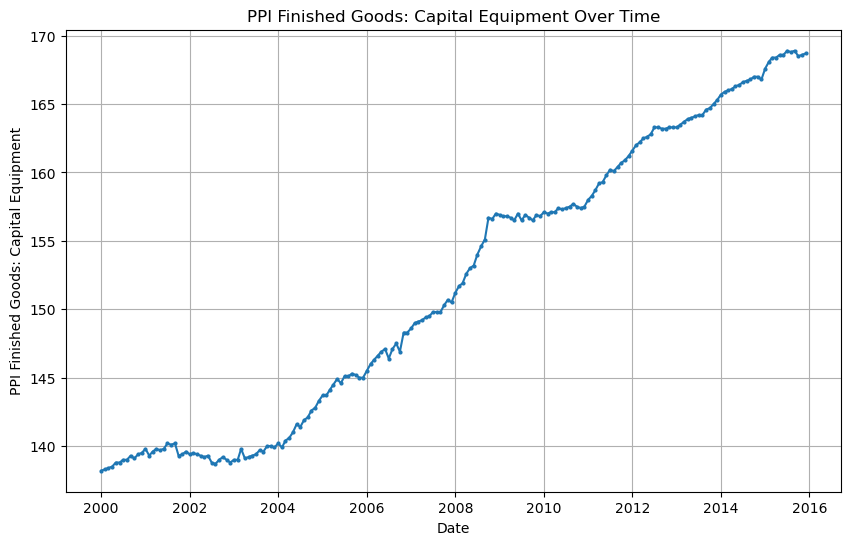

In [286]:
#distribution of PPI Finished Goods: Capital Equipment
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['PPI Finished Goods: Capital Equipment'], marker='o', linestyle='-', markersize=2)
plt.title('PPI Finished Goods: Capital Equipment Over Time')
plt.xlabel('Date')
plt.ylabel('PPI Finished Goods: Capital Equipment')
plt.grid(True)
plt.show()

- It seems like there is an approximately linear growth in each missing value column over time. Thus, it will be appropriate to use linear interplocation.

In [287]:
missing_value_columns = ['PPI Finished Goods: Capital Equipment','PPI: Finished Goods Less Food & Energy','Savings Deposits - Total']
for column in missing_value_columns:
    df[column] = df[column].interpolate(method='linear')

## Part 2. Shift each of the non-date variable down by 12 months 
- Notice that we will make predictions for sales units for the next year, so all features will not be avaiable at the time of prediction. Thus, we need to use the feature value from the same month but from the last year to make predictions. This can be down by shifting down the features by 12 rows.
    - Ex: At the end of 2020, we would like to predict sales units on 01-2021. However, the related feature such as Real Personal Consumption Expenditures during 01-2021 will not be available at the time of prediction. Thus, I will use the most recent & related value - Real Personal Consumption Expenditures during 01-2020.

In [288]:
shifted_df = df.copy()
shifted_df['Monthly_Sales_Units'] = shifted_df['Units']
shifted_df[shifted_df.columns.difference(['Date','Monthly_Sales_Units'])] = shifted_df[shifted_df.columns.difference(['Date','Monthly_Sales_Units'])].shift(12)
for column in shifted_df.columns.difference(['Date','Monthly_Sales_Units']):
    new_column = column + " Pre Month Year"
    shifted_df = shifted_df.rename(columns={column: new_column})
shifted_df = shifted_df.iloc[12:]
shifted_df.head(24)

Date  Units Pre Month Year  \
12 2001-01-01               14364.0   
13 2001-02-01               12192.0   
14 2001-03-01                9359.0   
15 2001-04-01               10460.0   
16 2001-05-01                7191.0   
17 2001-06-01               11274.0   
18 2001-07-01                5889.0   
19 2001-08-01               10137.0   
20 2001-09-01                9745.0   
21 2001-10-01                9822.0   
22 2001-11-01                8389.0   
23 2001-12-01                9957.0   
24 2002-01-01               11886.0   
25 2002-02-01                9088.0   
26 2002-03-01                8876.0   
27 2002-04-01                8929.0   
28 2002-05-01                7697.0   
29 2002-06-01                8520.0   
30 2002-07-01                7098.0   
31 2002-08-01                6592.0   
32 2002-09-01                7920.0   
33 2002-10-01                5968.0   
34 2002-11-01               12230.0   
35 2002-12-01                9594.0   

    Real Personal Consumption Expenditures Pre Month Year  \
12                                             7988.5       
13                                             8065.3       
14                                             8110.8       
15                                             8101.6       
16                                             8139.0       
17                                             8156.0       
18                                             8160.6       
19                                             8203.8       
20                                             8269.4       
21                                             8265.8       
22                                             8272.5       
23                                             8314.9       
24                                             8314.4       
25                                             8326.3       
26                                             8317.4       
27                                             8318.7       
28                                             8351.4       
29                                             8352.1       
30                                             8368.8       
31                                             8412.7       
32                                             8332.2       
33                                             8531.9       
34                                             8489.9       
35                                             8475.6       

    Real PCE: Durable Goods Pre Month Year  \
12                                   750.2   
13                                   770.5   
14                                   763.0   
15                                   745.3   
16                                   750.5   
17                                   745.6   
18                                   746.2   
19                                   756.9   
20                                   776.5   
21                                   769.0   
22                                   762.8   
23                                   763.5   
24                                   766.5   
25                                   787.9   
26                                   778.7   
27                                   765.7   
28                                   775.2   
29                                   790.2   
30                                   782.0   
31                                   800.7   
32                                   775.1   
33                                   883.5   
34                                   852.5   
35                                   818.3   

    Real PCE: Nondurable Goods Pre Month Year  \
12                                     1807.3   
13                                     1820.9   
14                                     1848.9   
15                                     1857.2   
16                                     1865.1   
17                                     1863.9   
18           

## Part 3. Remove Outliers

- Method 1: for each continuous varaible, remove rows where value is samller than q1 - 1.5 * IQR or greater than q3 + 1.5 * IQR

In [289]:
def remove_outliers(data, variable):
    q1 = data[variable].quantile(0.25)
    q3 = data[variable].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[variable] >= lower_bound) & (data[variable] <= upper_bound)]

df_method1 = shifted_df.copy()

continuous_vars = df_method1.columns.difference(['Date','Monthly_Sales'])
org_data_point_count = len(df_method1)

for var in continuous_vars:
    df_method1 = remove_outliers(df_method1, var)
    
outlier_count = org_data_point_count -  len(df_method1)

print("Number of data point:", org_data_point_count)
print("Number of outliers:", outlier_count)
print("Percentage of outliers out of total data points:", outlier_count/org_data_point_count)

Number of data point: 252
Number of outliers: 198
Percentage of outliers out of total data points: 0.7857142857142857


- Method 2: Isolation Forest. Since the number of data points is very limited, I will only remove 0.05 of data points as outliers.

In [290]:
warnings.filterwarnings("ignore")

df_method2 = shifted_df.copy()

model = IsolationForest(contamination=0.05)

features = df_method2.columns.difference(['Date', 'Monthly_Sales'])
X = df_method2[features]

outliers = model.fit_predict(X)
df_method2 = df_method2[outliers == 1]

print("Number of data point:", len(shifted_df))
print("Number of outliers:", len(shifted_df) - len(df_method2))
print("Percentage of outliers out of total data points:", round(1 - len(df_method2)/len(shifted_df),2))

Number of data point: 252
Number of outliers: 13
Percentage of outliers out of total data points: 0.05


- since method 1 will cut off too many data points, method 2 will be applied here

In [291]:
df_shifted = df_method2.copy()
df_shifted.head()

Date  Units Pre Month Year  \
15 2001-04-01               10460.0   
16 2001-05-01                7191.0   
17 2001-06-01               11274.0   
18 2001-07-01                5889.0   
19 2001-08-01               10137.0   

    Real Personal Consumption Expenditures Pre Month Year  \
15                                             8101.6       
16                                             8139.0       
17                                             8156.0       
18                                             8160.6       
19                                             8203.8       

    Real PCE: Durable Goods Pre Month Year  \
15                                   745.3   
16                                   750.5   
17                                   745.6   
18                                   746.2   
19                                   756.9   

    Real PCE: Nondurable Goods Pre Month Year  \
15                                     1857.2   
16                                     1865.1   
17                                     1863.9   
18                                     1862.4   
19                                     1873.1   

    Real PCE: Services Pre Month Year  \
15                             5552.5   
16                             5576.1   
17                             5603.3   
18                             5608.8   
19                             5627.0   

    Capacity Utilization: Total Industry Pre Month Year  \
15                                            82.3387     
16                                            82.3055     
17                                            82.0799     
18                                            81.6552     
19                                            81.1697     

    Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
15                                          1035.1754                      
16                                          1052.0214                      
17                                          1062.7664                      
18                                          1068.5736                      
19                                          1071.6904                      

    Industrial Production Index Pre Month Year  \
15                                     92.8872   
16                                     93.1620   
17                                     93.2168   
18                                     93.0400   
19                                     92.7900   

    Industrial Production Index - Mfg. Pre Month Year  \
15                                            93.8051   
16                                            93.8815   
17                                            94.0159   
18                                            94.0930   
19                                            93.4969   

    Inventories: Total Business Pre Month Year  \
15                                   1157552.0   
16                                   1163974.0   
17                                   1174263.0   
18                                   1175374.0   
19                                   1183268.0   

    Inventory to Sales Ratio: Total Business Pre Month Year  \
15                                               1.39         
16                                               1.40         
17                                               1.40         
18                                               1.41         
19                                               1.43         

    ISM INDEX: PMI Manufacturing Composite Index Pre Month Year  \
15                                               54.7             
16                                               53.2             
17                                               51.4             
18                                               52.5             
19                                               49.9             

    ISM INDEX Backlogs Pre Month Year  \
15      

# Section 7. Explotory Data Analysis

## Part 1. Unit Sales Over Time in Different Granuity (non-shift dataset)

- Unit Sales by Month and Year

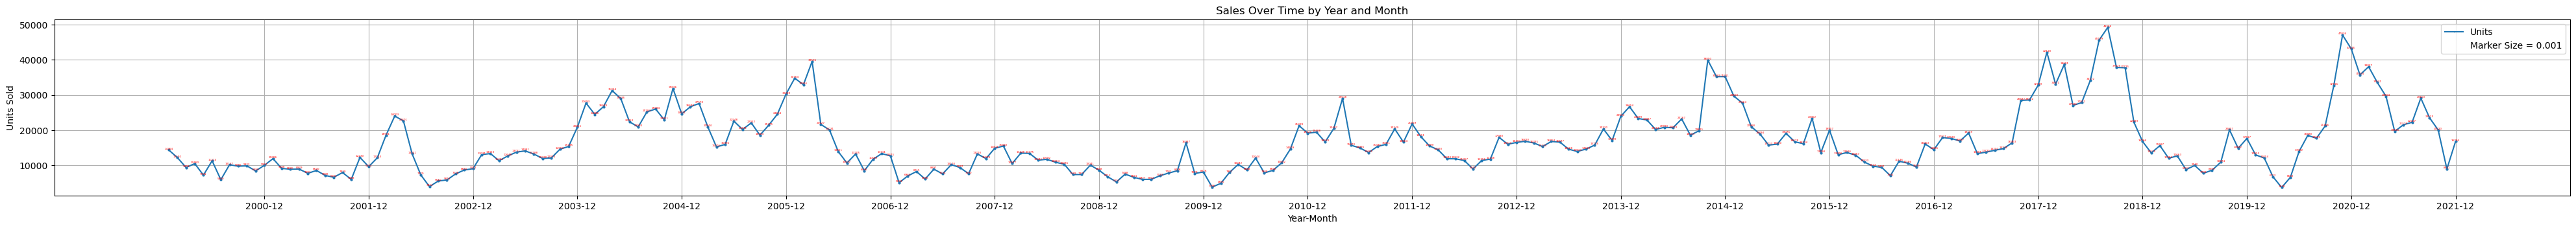

In [292]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
plt.figure(figsize=(50, 12))
ax1 = plt.subplot(3, 1, 1)
df_grouped = df.groupby(['Year', 'Month'])['Units'].sum()
df_grouped.plot(marker='o', linestyle='-', markersize=2)
plt.title('Sales Over Time by Year and Month')
plt.xlabel('Year-Month')
plt.ylabel('Units Sold')
plt.grid(True)
for i, (year, month, units) in enumerate(df_grouped.reset_index().values):
    ax1.text(i, units, str(int(units)), ha='center', va='bottom', fontsize=3, color='red')
ticks_at_12_months = [i*12 + df[df['Year'] == year]['Month'].max() - 1 for i, year in enumerate(sorted(df['Year'].unique()))]
ax1.set_xticks(ticks_at_12_months)
ax1.set_xticklabels([f"{year}-{df[df['Year'] == year]['Month'].max():02d}" for year in sorted(df['Year'].unique())])
ax1.plot([], [], ' ', label='Marker Size = 0.001')
ax1.legend(markerscale=0.1)
plt.show()

- Unit Sales by Quarter and Year

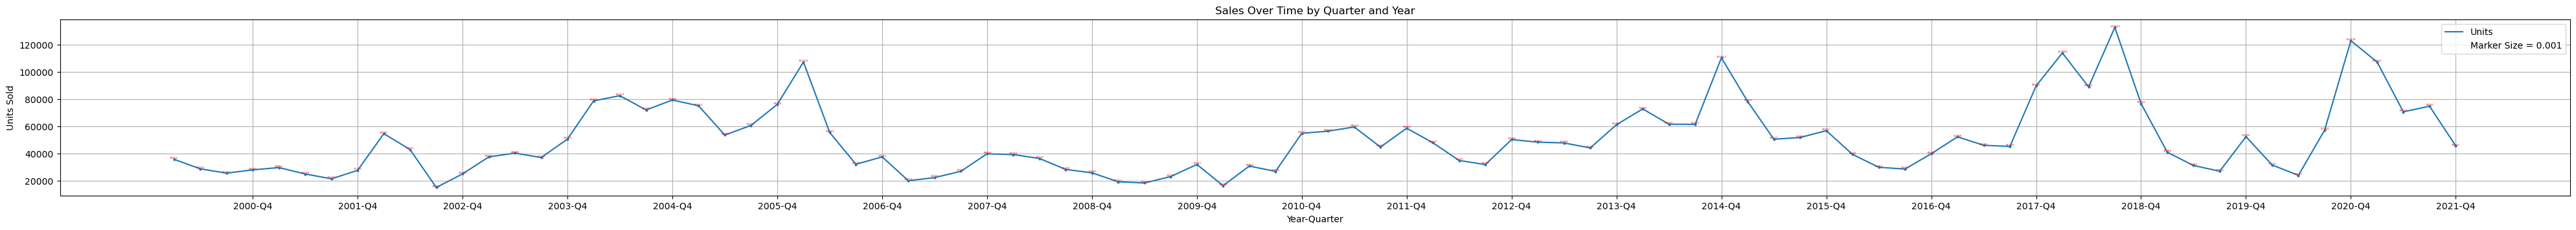

In [293]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
plt.figure(figsize=(50, 12))
ax1 = plt.subplot(3, 1, 1)
df_grouped = df.groupby(['Year', 'Quarter'])['Units'].sum()
df_grouped.plot(marker='o', linestyle='-', markersize=2)
plt.title('Sales Over Time by Quarter and Year')
plt.xlabel('Year-Quarter')
plt.ylabel('Units Sold')
plt.grid(True)
for i, (year, quarter, units) in enumerate(df_grouped.reset_index().values):
    ax1.text(i, units, str(int(units)), ha='center', va='bottom', fontsize=3, color='red')
ticks_at_4_quarters = [i*4 + df[df['Year'] == year]['Quarter'].max() - 1 for i, year in enumerate(sorted(df['Year'].unique()))]
ax1.set_xticks(ticks_at_4_quarters)
ax1.set_xticklabels([f"{year}-Q{df[df['Year'] == year]['Quarter'].max()}" for year in sorted(df['Year'].unique())])
ax1.plot([], [], ' ', label='Marker Size = 0.001')
ax1.legend(markerscale=0.1)
plt.show()

- Unit Sales by Year

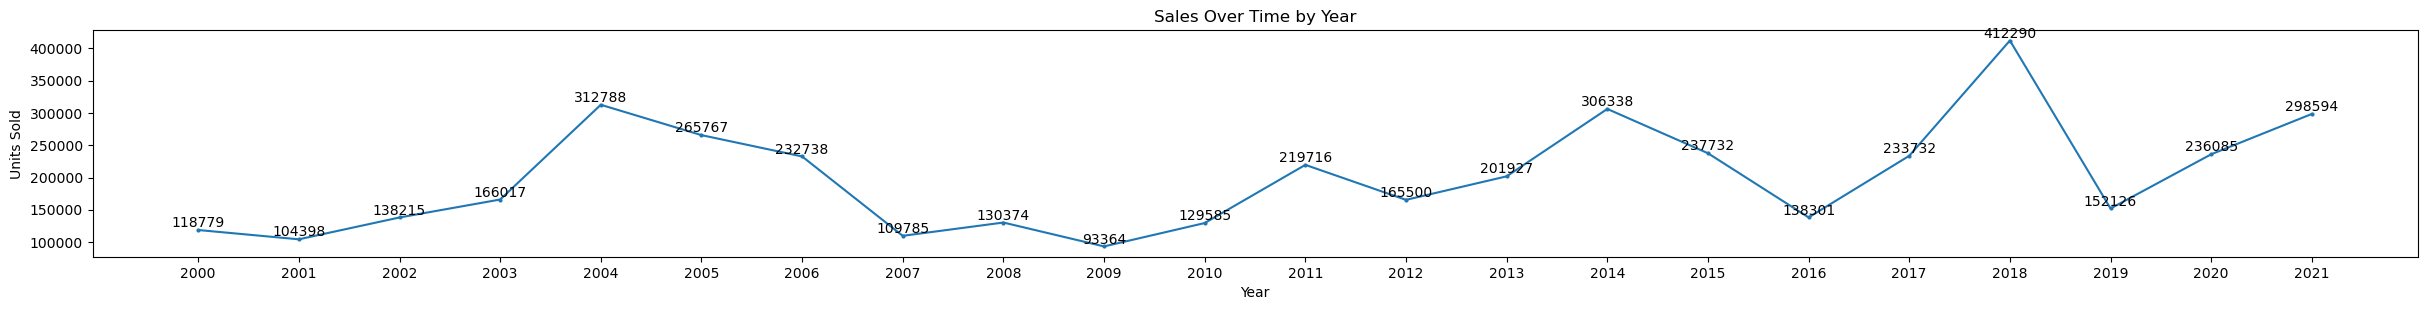

In [294]:
df['Year'] = df['Date'].dt.year
plt.figure(figsize=(30, 10))
ax1 = plt.subplot(3, 1, 1)
df_grouped = df.groupby('Year')['Units'].sum()
df_grouped.plot(marker='o', linestyle='-', markersize=2)
plt.xticks(df['Year'].unique())
for i, value in enumerate(df_grouped):
    plt.text(df_grouped.index[i], value, str(value), ha='center', va='bottom')
plt.title('Sales Over Time by Year')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.show()

- Key takeaways
    - There is no clear seasonal or monthly trend of sales.
    - There is a consecutive increase in yearly sales from 2019 to 2021. Based on the pattern of the dataset, it seems like there will be a decrease in sales following 3 consecutive increase in yearly sales. Thus, I will expect a decrease in sales in 2022.

## Part 2. Correlation Analysis (shifted dataset)

- Correlation Matrix

In [295]:
# correlation_matrix = shifted_df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

In [296]:
shifted_df.corr()

Units Pre Month Year  \
Units Pre Month Year                                            1.000000   
Real Personal Consumption Expenditures Pre Mont...              0.334052   
Real PCE: Durable Goods Pre Month Year                          0.364930   
Real PCE: Nondurable Goods Pre Month Year                       0.339387   
Real PCE: Services Pre Month Year                               0.306683   
Capacity Utilization: Total Industry Pre Month ...              0.307940   
Commercial and Industrial Loans, Commercial Ban...              0.191623   
Industrial Production Index Pre Month Year                      0.409465   
Industrial Production Index - Mfg. Pre Month Year               0.340995   
Inventories: Total Business Pre Month Year                      0.284584   
Inventory to Sales Ratio: Total Business Pre Mo...             -0.227843   
ISM INDEX: PMI Manufacturing Composite Index Pr...              0.580872   
ISM INDEX Backlogs Pre Month Year                               0.510870   
ISM INDEX Customer Inventories Pre Month Year                  -0.295548   
ISM INDEX Employment  Pre Month Year                            0.481927   
ISM INDEX Exports Pre Month Year                                0.354423   
ISM INDEX Imports Pre Month Year                                0.436367   
ISM INDEX Inventories Pre Month Year                            0.478660   
ISM INDEX New Orders Pre Month Year                             0.515812   
ISM INDEX Prices Pre Month Year                                 0.303783   
ISM INDEX Production Pre Month Year                             0.486396   
ISM INDEX Supplier deliveries Pre Month Year                    0.475770   
ISM NonMfg.: Business Activity Index Pre Month ...              0.491021   
Mfgs' New Orders: Nondefense Excluding Aircraft...              0.247455   
Retail and Food Services Sales Pre Month Year                   0.359894   
Retail Sales: Total (Excluding Food Services) P...              0.364544   
Consumer Loans at All Commercial Banks Pre Mont...              0.285609   
Housing Starts Total: New Privately Owned  Pre ...              0.207743   
New Private Housing Units Authorized by Buildin...              0.227254   
S&P Case-Shiller 20-City Home Price Index Pre M...              0.380746   
Autos & Light Trucks Pre Month Year                             0.294805   
Misery Index Pre Month Year                                    -0.142435   
Misery Index - Adjusted  Pre Month Year                        -0.166397   
New Residential Sales - Single Family Pre Month...              0.140675   
Personal Income Pre Month Year                                  0.287475   
Personal Saving Pre Month Year                                  0.120464   
Privately Owned Housing Starts: 1-Unit Structur...              0.169831   
Real Disposable Personal Income Pre Month Year                  0.286298   
Savings Deposits - Total Pre Month Year                         0.322000   
Total Consumer Credit Outstanding Pre Month Year                0.303826   
Total Population: Incl'd Armed Forces Overseas ...              0.283163   
Total Revolving Credit Outstanding Pre Month Year               0.138155   
University of Michigan: Consumer Sentiment Pre ...              0.234900   
Conference Board Consumer Confidence Pre Month ...              0.224915   
CPI Index - All Urban: All Items Pre Month Year                 0.277370   
CPI Index All Urban: Less Food & Energy Pre Mon...              0.279642   
Aggregate Weekly Hours Index: Total Private Ind...              0.304358   
Average Weekly Hours: Production & Nonsuper. Pr...              0.155541   
Civilian Participation Rate Pre Month Year                     -0.332747   
Total Unemployment Rate Plus (U6 Rate) Pre Mont...             -0.142011   
Civilian Unemployment Rate Pre Month Year                      -0.180220   
Nonfarm Payrolls: Mfg. Pre Month Year                          -0.173921   
Nonfarm Payrolls: All Em

- Correlation between Monthly_Sales_Units vs Other Variables
    - Sort the variables based on the absolute value of the correlation from the largest to the smallest.
    - It helps identify the most important features
        - Positive correlation indicates that increase in the related feature can boost the unit sales.
        - negative correlation indicates that decrease in the related feature can boost the unit sales.
    - Top 10 most correlated features for Monthly_Sales_Units are
| Features | Correlation with Monthly_Sales_Units |
|----------|----------|
| Mortgage Rate, 30-Year Conventional| -0.385 |
| Treasury Constant Maturity Rate, 5-Year | -0.351  |
| Treasury Constant Maturity Rate, 2-Year | -0.347  |
| Bank Prime Loan Rate Pre Month Year | -0.346 |
| Treasury Constant Maturity Rate, 10-Year | -0.346 |
| Savings Deposits - Total | 0.345  |
| Effective Federal Funds Rate | -0.344 |
| Treasury Constant Maturity Rate, 1-Year | -0.342   |
| Civilian Participation Rate | -0.333   |
| Mexico/U.S. Foreign Exchange Rate | 0.333 |
    - By closingly examine the top 10 most correlated features for Monthly_Sales_Units, the following inside can be found.
        - 1. Interest Rate (Negative Impact)
            - The most impactful features are interest rate and it has negative impact over monthly_sales_unit. It indicates that the price of truck can be expensive. People usually borrow money to purchase truck. Higher interest rate will increase the cost of borrowing, which can in turns leads to lower monthly_sales_unit.
        - 2. Savings Deposits (Positive Impact)
            - An increase in savings deposits typically indicates a higher capacity for individuals to make upfront payments, which is likely to contribute to a rise in Monthly Sales Units.
        - 3. Mexico/U.S. Foreign Exchange Rate (Positive Impact)
            - Positive Impact may be due to the following reasons:
                - An increase in Mexico/U.S. Foreign Exchange Rate increases the export to Mexico, which can lead to increased Monthly Sales Units.
                - Consumers and businesses may explore alternative countries for more affordable goods, such as Canada. Notably, the frequent use of trucks for transporting goods from Canada could result in an increased demand for trucks compared to deliveries from Mexico. This can also lead to increased Monthly Sales Units.

In [297]:
correlation_with_sales = shifted_df.corr()['Monthly_Sales_Units'].sort_values(ascending=False, key=abs)
print(correlation_with_sales)

Monthly_Sales_Units                                                          1.000000
Mortgage Rate, 30-Year Conventional  Pre Month Year                         -0.385266
Treasury Constant Maturity Rate, 5-Year  Pre Month Year                     -0.351077
Treasury Constant Maturity Rate, 2-Year  Pre Month Year                     -0.347103
Bank Prime Loan Rate Pre Month Year                                         -0.346267
Treasury Constant Maturity Rate, 10-Year  Pre Month Year                    -0.345945
Savings Deposits - Total Pre Month Year                                      0.345085
Effective Federal Funds Rate Pre Month Year                                 -0.344448
Treasury Constant Maturity Rate, 1-Year  Pre Month Year                     -0.341797
Civilian Participation Rate Pre Month Year                                  -0.333527
Mexico/U.S. Foreign Exchange Rate Pre Month Year                             0.332959
Treasury Bill: Secondary Market Rate, 3-Month  Pre Mon

## Part 3. Scatter plot - Monthly_Sales_Units against other features (shifted dataset)

- In this section, I will focus on features that have absolute correlation greater than 0.2 with Monthly_Sale_Units

In [298]:
filtered_correlations = correlation_with_sales[(correlation_with_sales > 0.2) | (correlation_with_sales < -0.2)]
features = list(filtered_correlations.index)
features

['Monthly_Sales_Units',
 'Mortgage Rate, 30-Year Conventional  Pre Month Year',
 'Treasury Constant Maturity Rate, 5-Year  Pre Month Year',
 'Treasury Constant Maturity Rate, 2-Year  Pre Month Year',
 'Bank Prime Loan Rate Pre Month Year',
 'Treasury Constant Maturity Rate, 10-Year  Pre Month Year',
 'Savings Deposits - Total Pre Month Year',
 'Effective Federal Funds Rate Pre Month Year',
 'Treasury Constant Maturity Rate, 1-Year  Pre Month Year',
 'Civilian Participation Rate Pre Month Year',
 'Mexico/U.S. Foreign Exchange Rate Pre Month Year',
 'Treasury Bill: Secondary Market Rate, 3-Month  Pre Month Year',
 'ATA Truck Tonnage Index (SA) Pre Month Year',
 'Consumer Loans at All Commercial Banks Pre Month Year',
 'Trucking Employment - General Freight, long TL - NSA Pre Month Year',
 'Total Consumer Credit Outstanding Pre Month Year',
 'Real PCE: Durable Goods Pre Month Year',
 'CPI Index All Urban: Less Food & Energy Pre Month Year',
 'Real PCE: Nondurable Goods Pre Month Year',
 "

- Pair Plot
    - Due to computation power limitation, I will only choose the top 10 features to make pair plot

In [299]:
index_list = list(range(1, 12))
name_list = shifted_df[features[:11]]
my_dict = dict(zip(index_list, name_list))
print("Variable Name Reference")
my_dict

Variable Name Reference


{1: 'Monthly_Sales_Units',
 2: 'Mortgage Rate, 30-Year Conventional  Pre Month Year',
 3: 'Treasury Constant Maturity Rate, 5-Year  Pre Month Year',
 4: 'Treasury Constant Maturity Rate, 2-Year  Pre Month Year',
 5: 'Bank Prime Loan Rate Pre Month Year',
 6: 'Treasury Constant Maturity Rate, 10-Year  Pre Month Year',
 7: 'Savings Deposits - Total Pre Month Year',
 8: 'Effective Federal Funds Rate Pre Month Year',
 9: 'Treasury Constant Maturity Rate, 1-Year  Pre Month Year',
 10: 'Civilian Participation Rate Pre Month Year',
 11: 'Mexico/U.S. Foreign Exchange Rate Pre Month Year'}

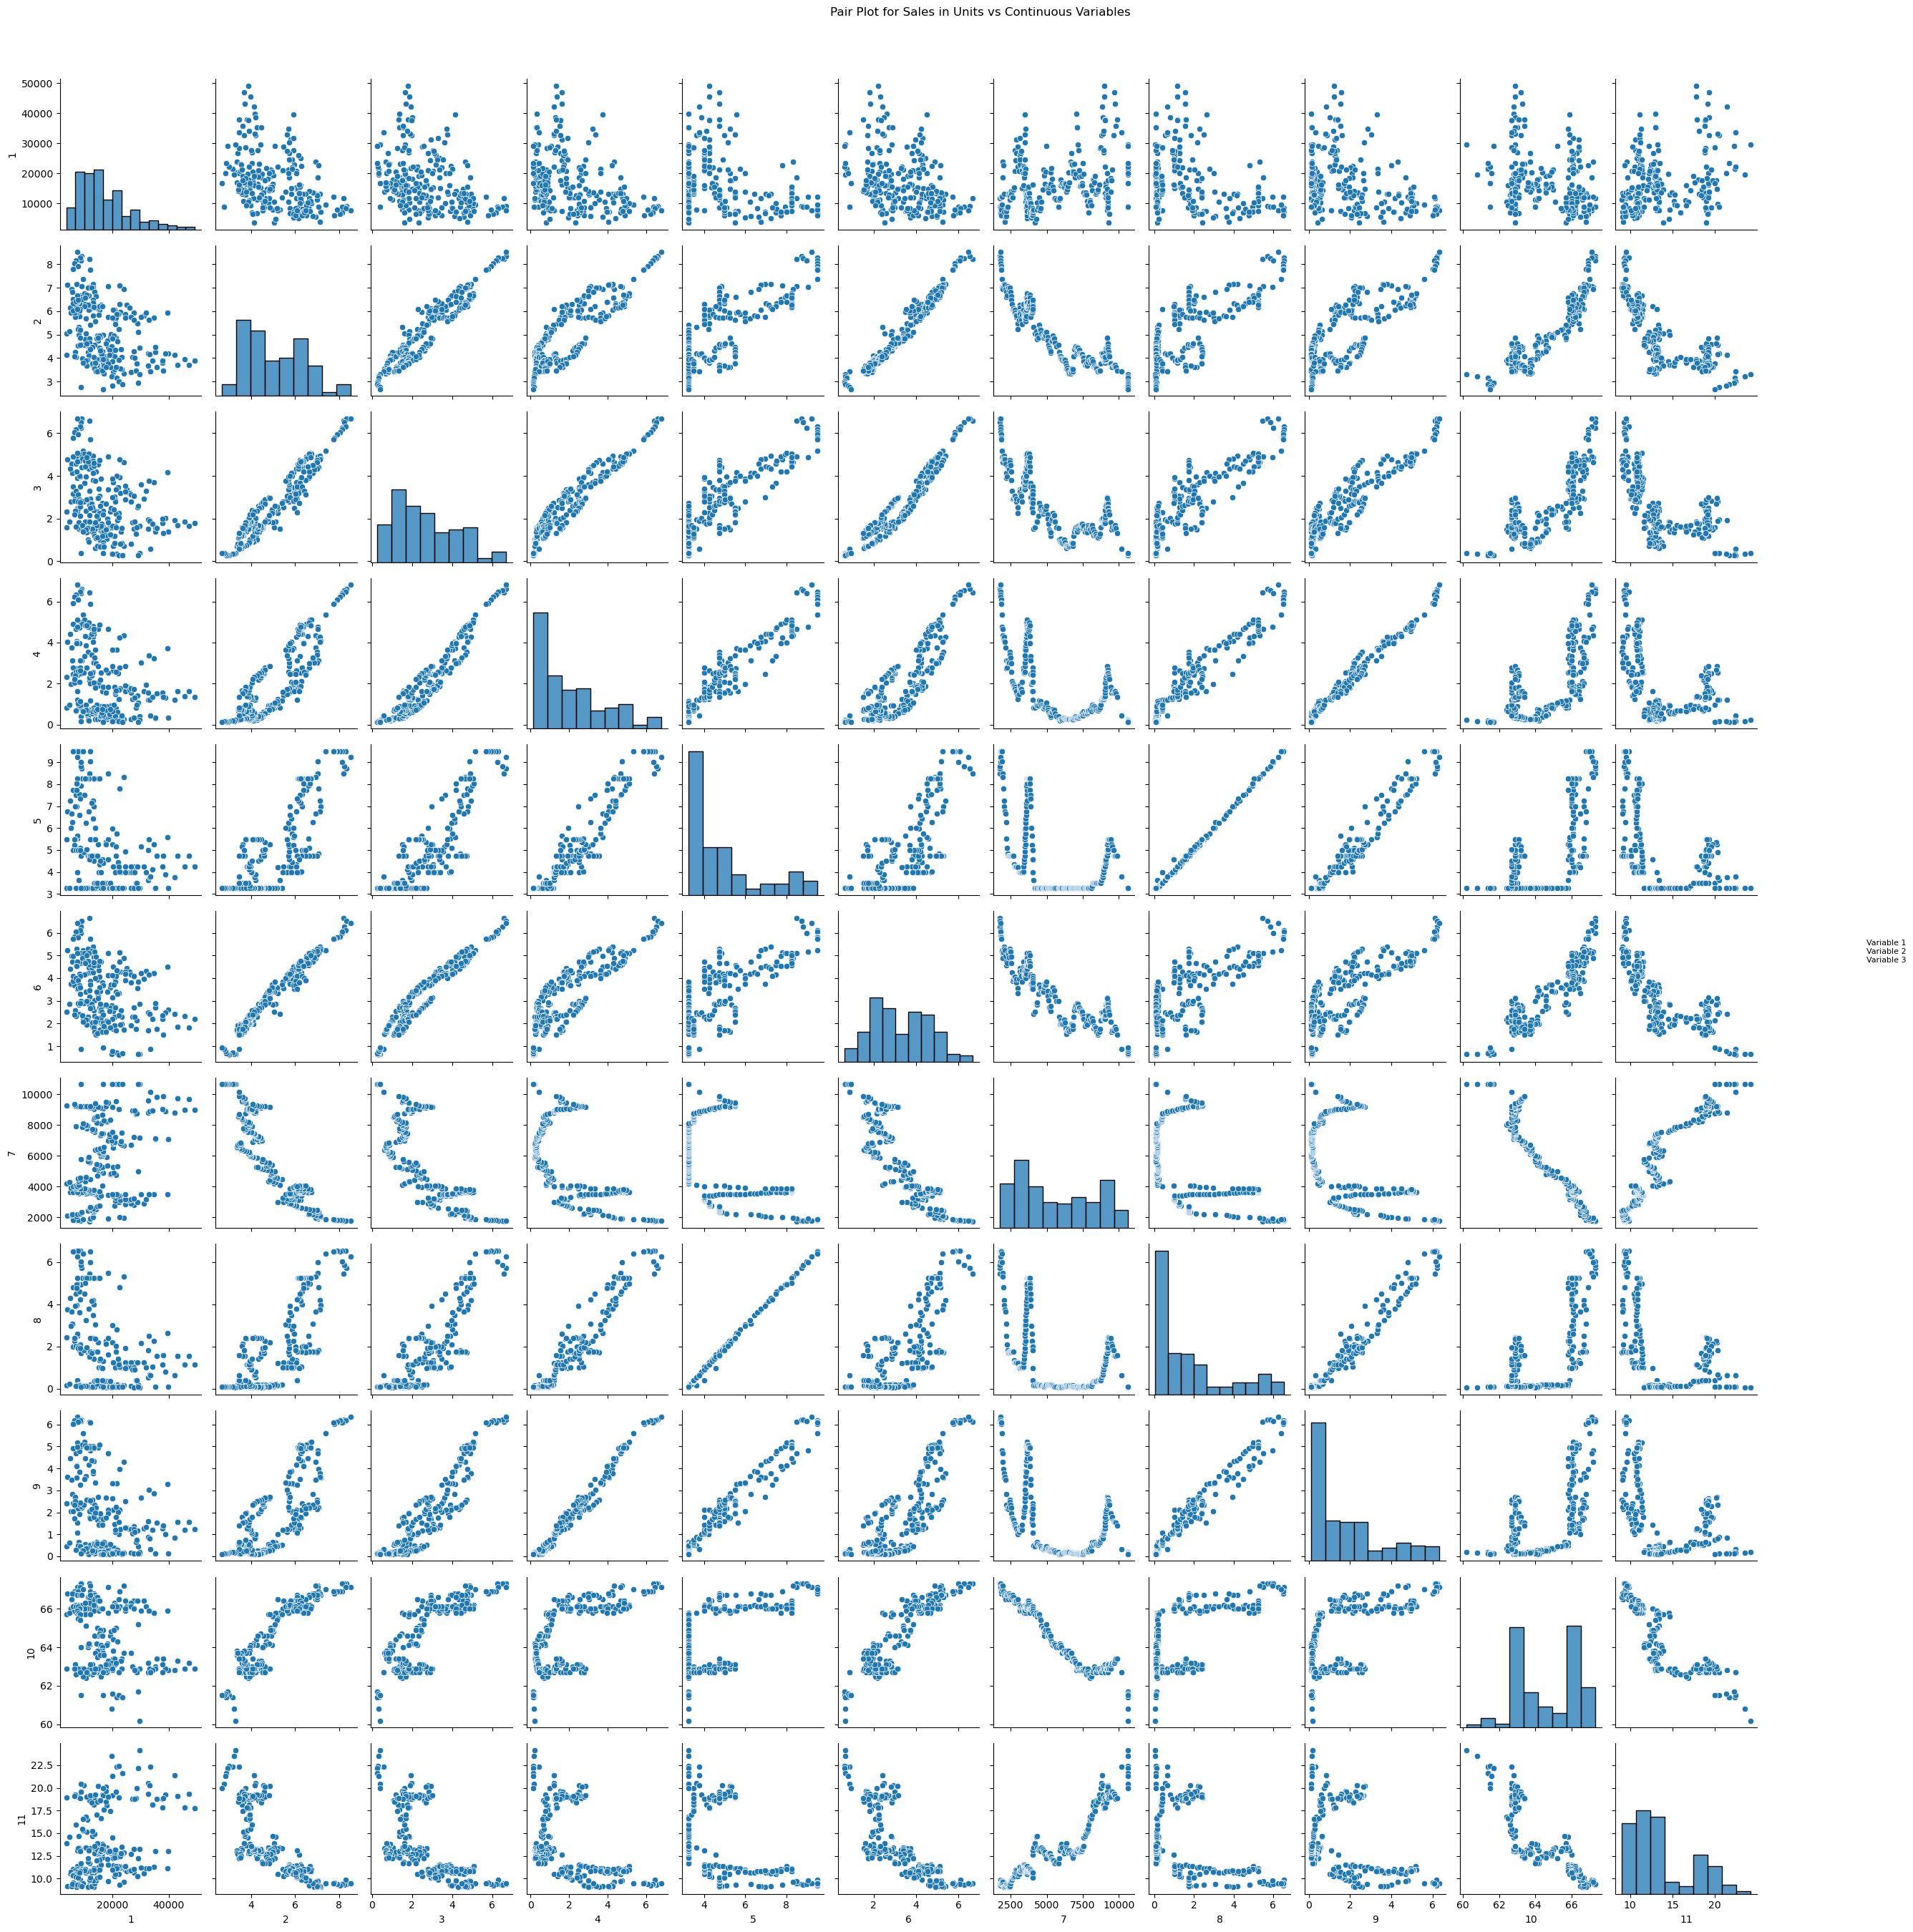

In [300]:
pair_plot_df = shifted_df[features[:11]].copy()
pair_plot_df.columns = index_list
pair_plot = sns.pairplot(pair_plot_df, kind='scatter')
pair_plot.fig.subplots_adjust(top=0.9)
pair_plot.fig.suptitle('Pair Plot for Sales in Units vs Continuous Variables', fontsize=12)
plt.figtext(0.95, 0.5, '\n'.join(legend_labels), fontsize=8, va='center', ha='left')
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()

# Section 8. Feature Engineering

## Part 1. Add Variable Year

In [301]:
shifted_df['Year'] = shifted_df['Date'].dt.year

In [302]:
shifted_df.head()

Date  Units Pre Month Year  \
12 2001-01-01               14364.0   
13 2001-02-01               12192.0   
14 2001-03-01                9359.0   
15 2001-04-01               10460.0   
16 2001-05-01                7191.0   

    Real Personal Consumption Expenditures Pre Month Year  \
12                                             7988.5       
13                                             8065.3       
14                                             8110.8       
15                                             8101.6       
16                                             8139.0       

    Real PCE: Durable Goods Pre Month Year  \
12                                   750.2   
13                                   770.5   
14                                   763.0   
15                                   745.3   
16                                   750.5   

    Real PCE: Nondurable Goods Pre Month Year  \
12                                     1807.3   
13                                     1820.9   
14                                     1848.9   
15                                     1857.2   
16                                     1865.1   

    Real PCE: Services Pre Month Year  \
12                             5476.5   
13                             5512.4   
14                             5543.5   
15                             5552.5   
16                             5576.1   

    Capacity Utilization: Total Industry Pre Month Year  \
12                                            82.0528     
13                                            82.0733     
14                                            82.1053     
15                                            82.3387     
16                                            82.3055     

    Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
12                                          1003.6370                      
13                                          1016.6491                      
14                                          1026.2262                      
15                                          1035.1754                      
16                                          1052.0214                      

    Industrial Production Index Pre Month Year  \
12                                     91.6261   
13                                     91.9626   
14                                     92.3118   
15                                     92.8872   
16                                     93.1620   

    Industrial Production Index - Mfg. Pre Month Year  \
12                                            92.2764   
13                                            92.5669   
14                                            93.1949   
15                                            93.8051   
16                                            93.8815   

    Inventories: Total Business Pre Month Year  \
12                                   1140023.0   
13                                   1146435.0   
14                                   1150666.0   
15                                   1157552.0   
16                                   1163974.0   

    Inventory to Sales Ratio: Total Business Pre Month Year  \
12                                               1.38         
13                                               1.40         
14                                               1.38         
15                                               1.39         
16                                               1.40         

    ISM INDEX: PMI Manufacturing Composite Index Pre Month Year  \
12                                               56.7             
13                                               55.8             
14                                               54.9             
15                                               54.7             
16                                               53.2             

    ISM INDEX Backlogs Pre Month Year  \
12      

## Part 2. Add Variable Quarter

In [303]:
shifted_df['Quarter'] = shifted_df['Date'].dt.quarter

In [304]:
shifted_df.head()

Date  Units Pre Month Year  \
12 2001-01-01               14364.0   
13 2001-02-01               12192.0   
14 2001-03-01                9359.0   
15 2001-04-01               10460.0   
16 2001-05-01                7191.0   

    Real Personal Consumption Expenditures Pre Month Year  \
12                                             7988.5       
13                                             8065.3       
14                                             8110.8       
15                                             8101.6       
16                                             8139.0       

    Real PCE: Durable Goods Pre Month Year  \
12                                   750.2   
13                                   770.5   
14                                   763.0   
15                                   745.3   
16                                   750.5   

    Real PCE: Nondurable Goods Pre Month Year  \
12                                     1807.3   
13                                     1820.9   
14                                     1848.9   
15                                     1857.2   
16                                     1865.1   

    Real PCE: Services Pre Month Year  \
12                             5476.5   
13                             5512.4   
14                             5543.5   
15                             5552.5   
16                             5576.1   

    Capacity Utilization: Total Industry Pre Month Year  \
12                                            82.0528     
13                                            82.0733     
14                                            82.1053     
15                                            82.3387     
16                                            82.3055     

    Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
12                                          1003.6370                      
13                                          1016.6491                      
14                                          1026.2262                      
15                                          1035.1754                      
16                                          1052.0214                      

    Industrial Production Index Pre Month Year  \
12                                     91.6261   
13                                     91.9626   
14                                     92.3118   
15                                     92.8872   
16                                     93.1620   

    Industrial Production Index - Mfg. Pre Month Year  \
12                                            92.2764   
13                                            92.5669   
14                                            93.1949   
15                                            93.8051   
16                                            93.8815   

    Inventories: Total Business Pre Month Year  \
12                                   1140023.0   
13                                   1146435.0   
14                                   1150666.0   
15                                   1157552.0   
16                                   1163974.0   

    Inventory to Sales Ratio: Total Business Pre Month Year  \
12                                               1.38         
13                                               1.40         
14                                               1.38         
15                                               1.39         
16                                               1.40         

    ISM INDEX: PMI Manufacturing Composite Index Pre Month Year  \
12                                               56.7             
13                                               55.8             
14                                               54.9             
15                                               54.7             
16                                               53.2             

    ISM INDEX Backlogs Pre Month Year  \
12      

## Part 3. Add Variable Month

In [305]:
shifted_df['Month'] = shifted_df['Date'].dt.month

In [306]:
shifted_df.head()

Date  Units Pre Month Year  \
12 2001-01-01               14364.0   
13 2001-02-01               12192.0   
14 2001-03-01                9359.0   
15 2001-04-01               10460.0   
16 2001-05-01                7191.0   

    Real Personal Consumption Expenditures Pre Month Year  \
12                                             7988.5       
13                                             8065.3       
14                                             8110.8       
15                                             8101.6       
16                                             8139.0       

    Real PCE: Durable Goods Pre Month Year  \
12                                   750.2   
13                                   770.5   
14                                   763.0   
15                                   745.3   
16                                   750.5   

    Real PCE: Nondurable Goods Pre Month Year  \
12                                     1807.3   
13                                     1820.9   
14                                     1848.9   
15                                     1857.2   
16                                     1865.1   

    Real PCE: Services Pre Month Year  \
12                             5476.5   
13                             5512.4   
14                             5543.5   
15                             5552.5   
16                             5576.1   

    Capacity Utilization: Total Industry Pre Month Year  \
12                                            82.0528     
13                                            82.0733     
14                                            82.1053     
15                                            82.3387     
16                                            82.3055     

    Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
12                                          1003.6370                      
13                                          1016.6491                      
14                                          1026.2262                      
15                                          1035.1754                      
16                                          1052.0214                      

    Industrial Production Index Pre Month Year  \
12                                     91.6261   
13                                     91.9626   
14                                     92.3118   
15                                     92.8872   
16                                     93.1620   

    Industrial Production Index - Mfg. Pre Month Year  \
12                                            92.2764   
13                                            92.5669   
14                                            93.1949   
15                                            93.8051   
16                                            93.8815   

    Inventories: Total Business Pre Month Year  \
12                                   1140023.0   
13                                   1146435.0   
14                                   1150666.0   
15                                   1157552.0   
16                                   1163974.0   

    Inventory to Sales Ratio: Total Business Pre Month Year  \
12                                               1.38         
13                                               1.40         
14                                               1.38         
15                                               1.39         
16                                               1.40         

    ISM INDEX: PMI Manufacturing Composite Index Pre Month Year  \
12                                               56.7             
13                                               55.8             
14                                               54.9             
15                                               54.7             
16                                               53.2             

    ISM INDEX Backlogs Pre Month Year  \
12      

## Part 4. Average Monthly Unit Sales for the Previous Year 
- Ex: For data point in 2021-05-01, this feature will be calculated as the average monthly sales for 2020. This columns will not be calculated in a rolling basis as average monthly sales from 2020-05-01 to 2021-04-01 becuase we would like to make predictions one year in advance. Thus, at the end of 2020, we would like to make prediction for 2021-05-01, but the data from 2021-01-01 to 2021-04-01 will not be available.
- Considering the limited size of the dataset, generating the Average Monthly Unit Sales for the Previous Multiple Years may not be practical, as it could result in the creation of numerous null value columns for the initial years

In [307]:
Average_Unit_Sale_Per_Year = shifted_df[['Units Pre Month Year','Year']].groupby('Year').mean()
Average_Unit_Sale_Per_Year = Average_Unit_Sale_Per_Year.rename(columns={"Units Pre Month Year":"Average Units Sale Pre Month Year"}).reset_index()
shifted_df = pd.merge(shifted_df, Average_Unit_Sale_Per_Year, on='Year')
shifted_df.head(24)

Date  Units Pre Month Year  \
0  2001-01-01               14364.0   
1  2001-02-01               12192.0   
2  2001-03-01                9359.0   
3  2001-04-01               10460.0   
4  2001-05-01                7191.0   
5  2001-06-01               11274.0   
6  2001-07-01                5889.0   
7  2001-08-01               10137.0   
8  2001-09-01                9745.0   
9  2001-10-01                9822.0   
10 2001-11-01                8389.0   
11 2001-12-01                9957.0   
12 2002-01-01               11886.0   
13 2002-02-01                9088.0   
14 2002-03-01                8876.0   
15 2002-04-01                8929.0   
16 2002-05-01                7697.0   
17 2002-06-01                8520.0   
18 2002-07-01                7098.0   
19 2002-08-01                6592.0   
20 2002-09-01                7920.0   
21 2002-10-01                5968.0   
22 2002-11-01               12230.0   
23 2002-12-01                9594.0   

    Real Personal Consumption Expenditures Pre Month Year  \
0                                              7988.5       
1                                              8065.3       
2                                              8110.8       
3                                              8101.6       
4                                              8139.0       
5                                              8156.0       
6                                              8160.6       
7                                              8203.8       
8                                              8269.4       
9                                              8265.8       
10                                             8272.5       
11                                             8314.9       
12                                             8314.4       
13                                             8326.3       
14                                             8317.4       
15                                             8318.7       
16                                             8351.4       
17                                             8352.1       
18                                             8368.8       
19                                             8412.7       
20                                             8332.2       
21                                             8531.9       
22                                             8489.9       
23                                             8475.6       

    Real PCE: Durable Goods Pre Month Year  \
0                                    750.2   
1                                    770.5   
2                                    763.0   
3                                    745.3   
4                                    750.5   
5                                    745.6   
6                                    746.2   
7                                    756.9   
8                                    776.5   
9                                    769.0   
10                                   762.8   
11                                   763.5   
12                                   766.5   
13                                   787.9   
14                                   778.7   
15                                   765.7   
16                                   775.2   
17                                   790.2   
18                                   782.0   
19                                   800.7   
20                                   775.1   
21                                   883.5   
22                                   852.5   
23                                   818.3   

    Real PCE: Nondurable Goods Pre Month Year  \
0                                      1807.3   
1                                      1820.9   
2                                      1848.9   
3                                      1857.2   
4                                      1865.1   
5                                      1863.9   
6            

## Part 5. Average Mortgage Rate, 30-Year Conventional Pre Month Year for the Previous Year

In [308]:
Average_Mortgage_Rate_Per_Year = shifted_df[['Mortgage Rate, 30-Year Conventional  Pre Month Year','Year']].groupby('Year').mean()
Average_Mortgage_Rate_Per_Year = Average_Mortgage_Rate_Per_Year.rename(columns={"Mortgage Rate, 30-Year Conventional  Pre Month Year":"Average Mortgage Rate, 30-Year Conventional Pre Month Year"}).reset_index()
shifted_df = pd.merge(shifted_df, Average_Mortgage_Rate_Per_Year, on='Year')
shifted_df.head(24)

Date  Units Pre Month Year  \
0  2001-01-01               14364.0   
1  2001-02-01               12192.0   
2  2001-03-01                9359.0   
3  2001-04-01               10460.0   
4  2001-05-01                7191.0   
5  2001-06-01               11274.0   
6  2001-07-01                5889.0   
7  2001-08-01               10137.0   
8  2001-09-01                9745.0   
9  2001-10-01                9822.0   
10 2001-11-01                8389.0   
11 2001-12-01                9957.0   
12 2002-01-01               11886.0   
13 2002-02-01                9088.0   
14 2002-03-01                8876.0   
15 2002-04-01                8929.0   
16 2002-05-01                7697.0   
17 2002-06-01                8520.0   
18 2002-07-01                7098.0   
19 2002-08-01                6592.0   
20 2002-09-01                7920.0   
21 2002-10-01                5968.0   
22 2002-11-01               12230.0   
23 2002-12-01                9594.0   

    Real Personal Consumption Expenditures Pre Month Year  \
0                                              7988.5       
1                                              8065.3       
2                                              8110.8       
3                                              8101.6       
4                                              8139.0       
5                                              8156.0       
6                                              8160.6       
7                                              8203.8       
8                                              8269.4       
9                                              8265.8       
10                                             8272.5       
11                                             8314.9       
12                                             8314.4       
13                                             8326.3       
14                                             8317.4       
15                                             8318.7       
16                                             8351.4       
17                                             8352.1       
18                                             8368.8       
19                                             8412.7       
20                                             8332.2       
21                                             8531.9       
22                                             8489.9       
23                                             8475.6       

    Real PCE: Durable Goods Pre Month Year  \
0                                    750.2   
1                                    770.5   
2                                    763.0   
3                                    745.3   
4                                    750.5   
5                                    745.6   
6                                    746.2   
7                                    756.9   
8                                    776.5   
9                                    769.0   
10                                   762.8   
11                                   763.5   
12                                   766.5   
13                                   787.9   
14                                   778.7   
15                                   765.7   
16                                   775.2   
17                                   790.2   
18                                   782.0   
19                                   800.7   
20                                   775.1   
21                                   883.5   
22                                   852.5   
23                                   818.3   

    Real PCE: Nondurable Goods Pre Month Year  \
0                                      1807.3   
1                                      1820.9   
2                                      1848.9   
3                                      1857.2   
4                                      1865.1   
5                                      1863.9   
6            

# Section 9. Data Preprocessing - Handling Categorical Variable
- Categorical variable in the datasets are Month and quarter
- first category in each categorical vairable will be dropped to aovid multi-collinearity problem
    - Month: January is dropped
    - Quarter: First quarter is dropped

In [309]:
shifted_df_encoded = pd.get_dummies(shifted_df, columns=['Quarter', 'Month'],drop_first=True)
shifted_df_encoded.head()

Date  Units Pre Month Year  \
0 2001-01-01               14364.0   
1 2001-02-01               12192.0   
2 2001-03-01                9359.0   
3 2001-04-01               10460.0   
4 2001-05-01                7191.0   

   Real Personal Consumption Expenditures Pre Month Year  \
0                                             7988.5       
1                                             8065.3       
2                                             8110.8       
3                                             8101.6       
4                                             8139.0       

   Real PCE: Durable Goods Pre Month Year  \
0                                   750.2   
1                                   770.5   
2                                   763.0   
3                                   745.3   
4                                   750.5   

   Real PCE: Nondurable Goods Pre Month Year  \
0                                     1807.3   
1                                     1820.9   
2                                     1848.9   
3                                     1857.2   
4                                     1865.1   

   Real PCE: Services Pre Month Year  \
0                             5476.5   
1                             5512.4   
2                             5543.5   
3                             5552.5   
4                             5576.1   

   Capacity Utilization: Total Industry Pre Month Year  \
0                                            82.0528     
1                                            82.0733     
2                                            82.1053     
3                                            82.3387     
4                                            82.3055     

   Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
0                                          1003.6370                      
1                                          1016.6491                      
2                                          1026.2262                      
3                                          1035.1754                      
4                                          1052.0214                      

   Industrial Production Index Pre Month Year  \
0                                     91.6261   
1                                     91.9626   
2                                     92.3118   
3                                     92.8872   
4                                     93.1620   

   Industrial Production Index - Mfg. Pre Month Year  \
0                                            92.2764   
1                                            92.5669   
2                                            93.1949   
3                                            93.8051   
4                                            93.8815   

   Inventories: Total Business Pre Month Year  \
0                                   1140023.0   
1                                   1146435.0   
2                                   1150666.0   
3                                   1157552.0   
4                                   1163974.0   

   Inventory to Sales Ratio: Total Business Pre Month Year  \
0                                               1.38         
1                                               1.40         
2                                               1.38         
3                                               1.39         
4                                               1.40         

   ISM INDEX: PMI Manufacturing Composite Index Pre Month Year  \
0                                               56.7             
1                                               55.8             
2                                               54.9             
3                                               54.7             
4                                               53.2             

   ISM INDEX Backlogs Pre Month Year  \
0                               52.0   
1                               54.0   


# Section 10. Train Test Split
- development data set will be the data from the beginning to the end of year 2020
- test data set will be the data for the year 2021
- Due to the limited size of the dataset, no validation set will be seperated out. Cross-validation will be used to do hyper-parameter tunning

In [316]:
development_data = shifted_df_encoded.iloc[:239]
test_data = shifted_df_encoded.iloc[240:]
X_dev = development_data.drop(columns=['Date','Monthly_Sales_Units'])
X_test = test_data.drop(columns=['Date','Monthly_Sales_Units'])
y_dev = development_data['Monthly_Sales_Units']
y_test = test_data['Monthly_Sales_Units']

In [317]:
development_data.tail(10)

Date  Units Pre Month Year  \
229 2020-02-01               15587.0   
230 2020-03-01               11986.0   
231 2020-04-01               12663.0   
232 2020-05-01                8757.0   
233 2020-06-01                9940.0   
234 2020-07-01                7709.0   
235 2020-08-01                8599.0   
236 2020-09-01               10874.0   
237 2020-10-01               20057.0   
238 2020-11-01               14822.0   

     Real Personal Consumption Expenditures Pre Month Year  \
229                                            12948.2       
230                                            13028.8       
231                                            13055.6       
232                                            13086.5       
233                                            13124.2       
234                                            13161.9       
235                                            13199.4       
236                                            13215.4       
237                                            13223.1       
238                                            13266.6       

     Real PCE: Durable Goods Pre Month Year  \
229                                  1681.0   
230                                  1722.1   
231                                  1726.0   
232                                  1740.7   
233                                  1745.8   
234                                  1760.7   
235                                  1770.8   
236                                  1787.9   
237                                  1775.7   
238                                  1802.5   

     Real PCE: Nondurable Goods Pre Month Year  \
229                                     2938.5   
230                                     2956.4   
231                                     2976.6   
232                                     2981.7   
233                                     2997.8   
234                                     3004.8   
235                                     3018.6   
236                                     3001.1   
237                                     3014.9   
238                                     3008.7   

     Real PCE: Services Pre Month Year  \
229                             8370.5   
230                             8400.1   
231                             8405.1   
232                             8418.8   
233                             8436.6   
234                             8454.7   
235                             8470.6   
236                             8487.6   
237                             8491.8   
238                             8517.8   

     Capacity Utilization: Total Industry Pre Month Year  \
229                                            78.9453     
230                                            78.9401     
231                                            78.4685     
232                                            78.5379     
233                                            78.4694     
234                                            78.0855     
235                                            78.5382     
236                                            78.2029     
237                                            77.5138     
238                                            77.6879     

     Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
229                                          2327.7885                      
230                                          2335.6059                      
231                                          2325.5988                      
232                                          2326.4650                      
233                                          2334.2327                      
234                                          2344.2853                      
235                                          2363.0470                      
236                                          2369.8587                      


In [318]:
test_data

Date  Units Pre Month Year  \
240 2021-01-01               12955.0   
241 2021-02-01               12054.0   
242 2021-03-01                6712.0   
243 2021-04-01                3678.0   
244 2021-05-01                6552.0   
245 2021-06-01               13922.0   
246 2021-07-01               18488.0   
247 2021-08-01               17680.0   
248 2021-09-01               21166.0   
249 2021-10-01               32716.0   
250 2021-11-01               47036.0   
251 2021-12-01               43126.0   

     Real Personal Consumption Expenditures Pre Month Year  \
240                                            13307.3       
241                                            13313.2       
242                                            12422.9       
243                                            10910.6       
244                                            11833.0       
245                                            12525.6       
246                                            12706.4       
247                                            12793.5       
248                                            12962.5       
249                                            13015.6       
250                                            12943.5       
251                                            12824.6       

     Real PCE: Durable Goods Pre Month Year  \
240                                  1815.5   
241                                  1811.0   
242                                  1588.5   
243                                  1419.6   
244                                  1810.5   
245                                  1965.1   
246                                  2015.9   
247                                  2025.8   
248                                  2050.1   
249                                  2074.7   
250                                  2044.4   
251                                  1990.2   

     Real PCE: Nondurable Goods Pre Month Year  \
240                                     3010.9   
241                                     3012.3   
242                                     3162.2   
243                                     2756.9   
244                                     2982.1   
245                                     3108.4   
246                                     3144.1   
247                                     3130.9   
248                                     3204.7   
249                                     3194.6   
250                                     3161.7   
251                                     3096.9   

     Real PCE: Services Pre Month Year  \
240                             8543.5   
241                             8550.4   
242                             7759.4   
243                             6814.4   
244                             7205.7   
245                             7631.9   
246                             7733.0   
247                             7817.1   
248                             7895.4   
249                             7935.2   
250                             7917.1   
251                             7898.6   

     Capacity Utilization: Total Industry Pre Month Year  \
240                                            76.9769     
241                                            77.2526     
242                                            74.3330     
243                                            64.5298     
244                                            65.5992     
245                                            69.7637     
246                                            72.4928     
247                                            73.2570     
248                                            73.3395     
249                                            74.0482     
250                                            74.4156     
251                                            75.3466     

     Commercial and Industrial Loans, Commercial Banks, SA Pre Month Year  \
240           

# Section 11. Model Development
- Evaluation Metrix Selection
    - Three metrics can be utilized for evaluating regression models: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2).
    - In this specific scenario, our primary focus is on assessing the proximity of our predictions to the actual unit sales. Therefore, we will consider MSE and MAE as suitable metrics.
    - Upon examining the distribution of Monthly Sales Units, it becomes evident that it is left-skewed. Given that MSE is highly sensitive to outliers, we opt for MAE in this case. MAE provides a more robust measure, particularly when dealing with skewed distributions

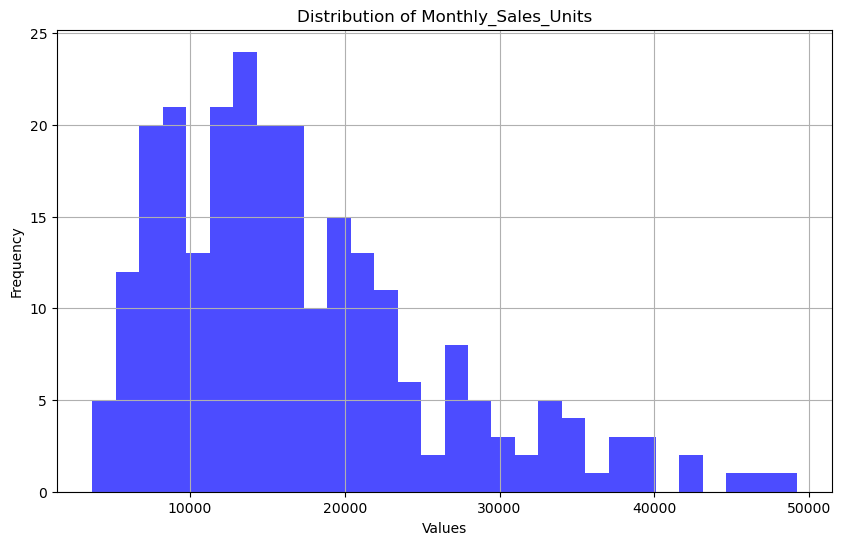

In [491]:
plt.figure(figsize=(10, 6))
plt.hist(shifted_df_encoded['Monthly_Sales_Units'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Monthly_Sales_Units')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Model 1. Linear Regression
- Data Standardization
    - Data set will be standardized using standard scaler
- Lasso will be used to do feature selection since the model has so many features, but the number of data points is limited. (Curse of dimensionality)
- Lasso penalty will be the hyper-parameter


### Hyper-parameter tunning

In [486]:
param_grid_lasso = {
    'regressor__alpha': list(range(1,81)),
}
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso())
])
grid_search_lasso = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
grid_search_lasso.fit(X_dev, y_dev)
best_params_lasso = grid_search_lasso.best_params_
print("Best parameters for Lasso Regression:", best_params_lasso)
mae_validation_score = -grid_search_lasso.best_score_
print("Validation Score (MAE):", mae_validation_score)

Best parameters for Lasso Regression: {'regressor__alpha': 75}
Validation Score (MAE): 8536.210992887285


### Model Interpretability
- Order of the feature is based on the absolute value of the coefficient from the largest to the smallest

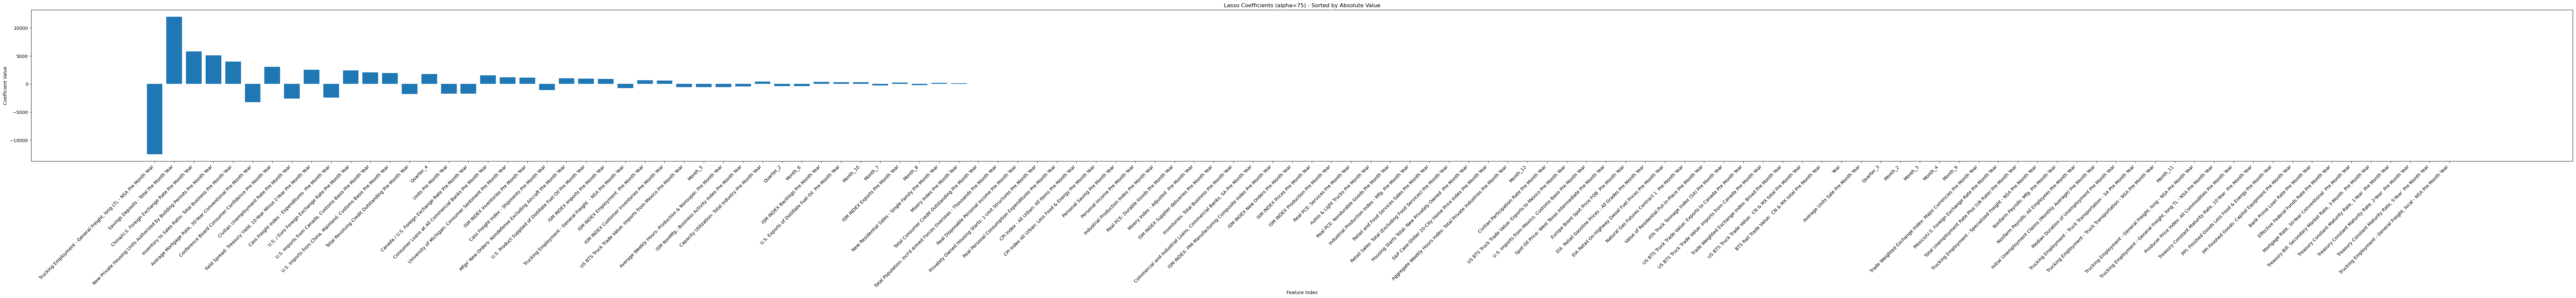

In [487]:
lasso_alpha = 75
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=lasso_alpha))
])
lasso_pipeline.fit(X_dev, y_dev)

coefficients = lasso_pipeline.named_steps['regressor'].coef_
feature_names = np.array(X_dev.columns)

sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(100, 6))
plt.bar(range(len(sorted_coefficients)), sorted_coefficients)
plt.title(f'Lasso Coefficients (alpha={lasso_alpha}) - Sorted by Absolute Value')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.xticks(range(len(sorted_coefficients)), sorted_feature_names, rotation=45, ha='right')
plt.show()

### Performance over Test Data Set

In [488]:
predictions = lasso_pipeline.predict(X_test)
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'Test R^2: {r2:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')

result_df = pd.DataFrame({'y_actual': y_test, 'y_prediction': predictions})
print(result_df)

Test R^2: 0.2698
Test MSE: 48441348.0667
Test MAE: 5864.5695
     y_actual  y_prediction
240     35704  29115.994292
241     38027  24681.449615
242     33531  29360.954871
243     29604  30249.898426
244     19620  27556.461852
245     21519  24440.981733
246     22217  20731.891449
247     29100  21519.072734
248     23525  19686.465157
249     20020  26985.484363
250      8941  20665.665853
251     16786  19958.169642


## Model 2. Random Forest
- Data standardization
    - Data set will be standardized using standard scaler
- Feature selection will be based on the feature importance
- Hyper-parameter
    - number of trees
    - number of features to be consider when developing individual tree
    - decision tree - related parameters:
        - max depth
        - max leaf nodes
        - minimum sample split
        - minimum impurity decrease

### Hyper-parameter tunning

In [389]:
param_grid_rf = {
    'regressor__n_estimators': [10, 20, 30, 40, 50, 60,  100, 125, 150, 175, 200, 225],
    'regressor__max_depth': [None, 5, 10, 15, 20, 25, 30, 35],
    'regressor__max_features': ['sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
grid_search_rf.fit(X_dev, y_dev)

best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest Regression:", best_params_rf)

mae_validation_score_rf = -grid_search_rf.best_score_
print("Validation Score (MAE) for Random Forest:", mae_validation_score_rf)

Best parameters for Random Forest Regression: {'regressor__max_depth': None, 'regressor__max_features': 'log2', 'regressor__n_estimators': 60}
Validation Score (MAE) for Random Forest: 7117.359838947991


### Feature importance and feature selection

- plot the feature importance

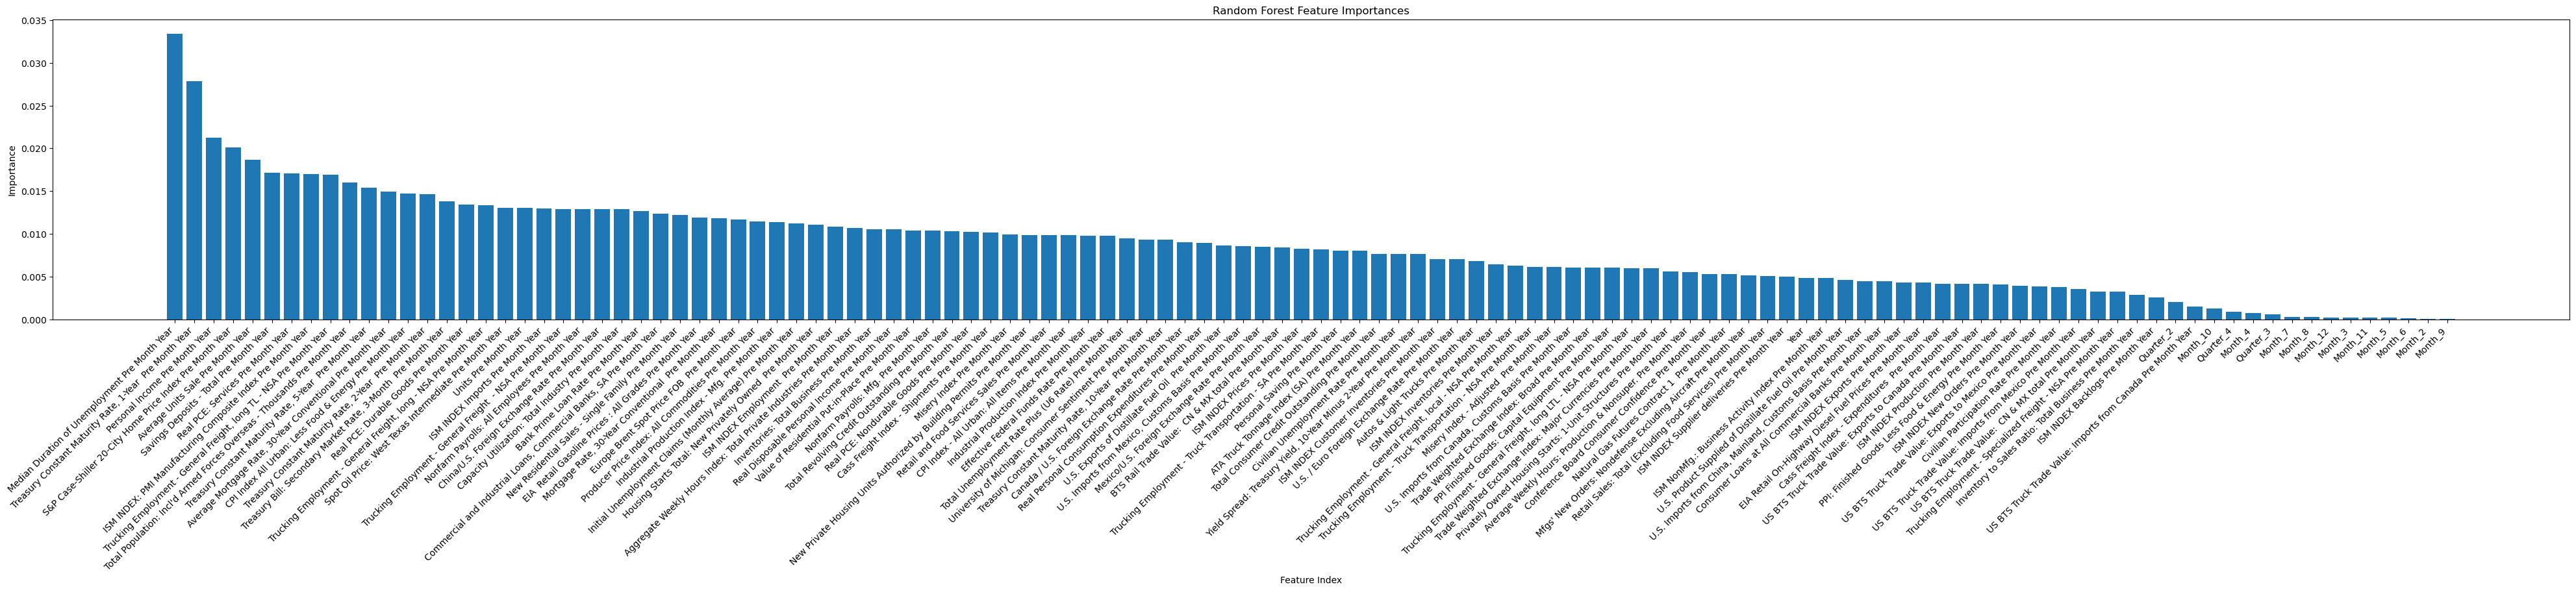

In [390]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(max_depth=None, max_features='log2', n_estimators=60, random_state=42))
])
rf_pipeline.fit(X_dev, y_dev)

importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_names = X_dev.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(50, 6))
plt.bar(range(len(importances)), importances[indices])
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.show()

- rule of thumb idea number of features will be 1/20 of the number of data points. There are approximately 200 data points. Thus, I will pick the top 10 features based on the feature importance.
- notice the validation performance is higher when selecting only the top 10 features.

In [391]:
top_10_indices = indices[:10]
top_10_feature_names = feature_names[top_10_indices]

rf_pipeline_feature_selection = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(n_estimators=25, max_depth=None, max_features='log2', random_state=42))
])

scoring_metric = make_scorer(mean_absolute_error, greater_is_better=False)  # Use negation for greater_is_better=False
cv_results = cross_validate(rf_pipeline_feature_selection, X_dev[top_10_feature_names], y_dev, cv=5, scoring=scoring_metric, return_train_score=True)

mae_validation_scores = -cv_results['test_score'].mean()
print("Validation Scores (MAE) for Random Forest with Top 10 Features:", mae_validation_scores)
print("Mean Validation Score (MAE):", np.mean(mae_validation_scores))

Validation Scores (MAE) for Random Forest with Top 10 Features: 6608.491709219859
Mean Validation Score (MAE): 6608.491709219859


### Performance over Test Data Set

In [392]:
rf_pipeline_feature_selection.fit(X_dev[top_10_feature_names], y_dev)
predictions = rf_pipeline_feature_selection.predict(X_test[top_10_feature_names])
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'Test R^2: {r2:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')

result_df = pd.DataFrame({'y_actual': y_test, 'y_prediction': predictions})
print(result_df)

Test R^2: 0.2052
Test MSE: 52725986.6763
Test MAE: 5778.6933
     y_actual  y_prediction
240     35704      31621.92
241     38027      27718.44
242     33531      20460.68
243     29604      21350.72
244     19620      23396.64
245     21519      22598.24
246     22217      23213.56
247     29100      22156.00
248     23525      22156.00
249     20020      21375.32
250      8941      22383.56
251     16786      21452.76


## Model 3. XGBoost
- Data standardization
    - Data set will be standardized using standard scaler
- Feature selection will be based on the feature importance
- Hyper-parameter
    - number of trees
    - learning rate
    - decision tree - related parameters:
        - max depth
        - max leaf nodes
        - minimum sample split
        - minimum impurity decrease

### Hyper-parameter tunning

In [477]:
param_grid_xgboost = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [4, 7, 9, 10, 15, 20],
    'regressor__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
}

# Create the XGBoost pipeline
xgboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Perform grid search with cross-validation
grid_search_xgboost = GridSearchCV(xgboost_pipeline, param_grid_xgboost, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
grid_search_xgboost.fit(X_dev, y_dev)

# Get the best parameters and validation score
best_params_xgboost = grid_search_xgboost.best_params_
print("Best parameters for XGBoost Regression:", best_params_xgboost)

mae_validation_score_xgboost = -grid_search_xgboost.best_score_
print("Validation Score (MAE) for XGBoost:", mae_validation_score_xgboost)

Best parameters for XGBoost Regression: {'regressor__learning_rate': 0.04, 'regressor__max_depth': 10, 'regressor__n_estimators': 100}
Validation Score (MAE) for XGBoost: 6944.537769507008


### Feature importance and feature selection

- plot feature importance

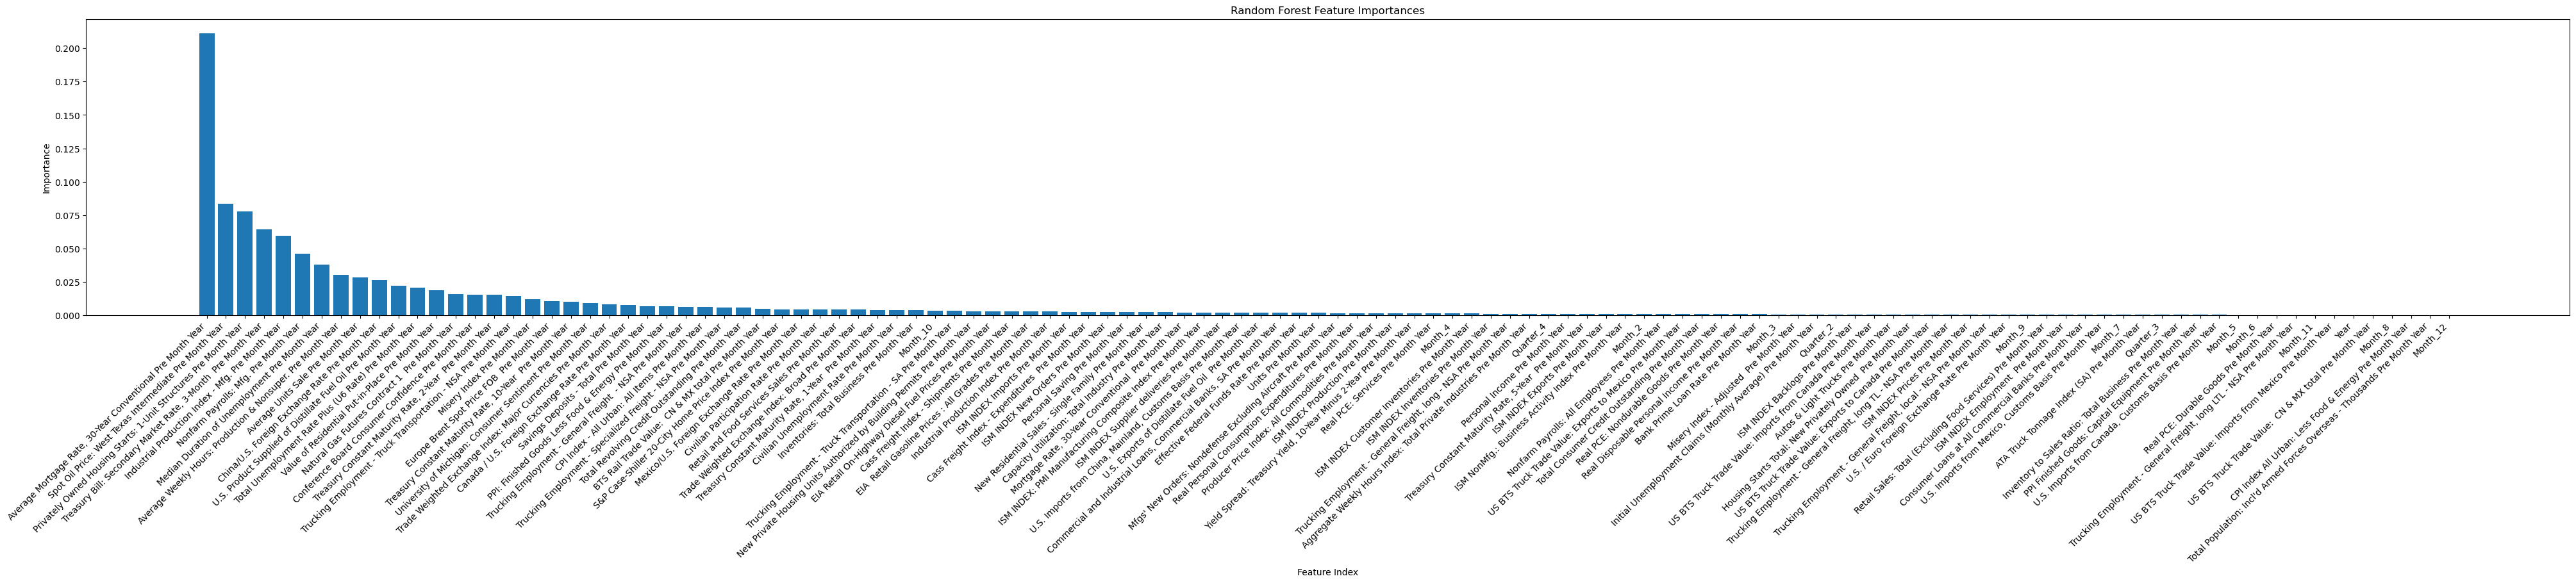

In [478]:
xgboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(learning_rate=0.04, max_depth=10, n_estimators=100, random_state=42, objective='reg:squarederror'))
])
xgboost_pipeline.fit(X_dev, y_dev)

importances = xgboost_pipeline.named_steps['regressor'].feature_importances_
feature_names = X_dev.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(50, 6))
plt.bar(range(len(importances)), importances[indices])
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.show()

- rule of thumb idea number of features will be 1/20 of the number of data points. There are approximately 200 data points. Thus, I will pick the top 10 features based on the feature importance.
- notice the validation performance is higher when selecting only the top 10 features.

In [484]:
#calculate validation score after performing feature selection
top_10_indices = indices[:10]
top_10_feature_names = feature_names[top_10_indices]

xgboost_pipeline_feature_selection = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(learning_rate=0.04, max_depth=10, n_estimators=100, random_state=42, objective='reg:squarederror'))
])

scoring_metric = make_scorer(mean_absolute_error, greater_is_better=False)
cv_results = cross_validate(xgboost_pipeline_feature_selection, X_dev[top_10_feature_names], y_dev, cv=5, scoring=scoring_metric, return_train_score=True)

mae_validation_scores = -cv_results['test_score'].mean()
print("Validation Scores (MAE) for Random Forest with Top 10 Features:", mae_validation_scores)
print("Mean Validation Score (MAE):", np.mean(mae_validation_scores))

Validation Scores (MAE) for Random Forest with Top 10 Features: 6901.188702912026
Mean Validation Score (MAE): 6901.188702912026


### Performance over Test Data Set

In [485]:
xgboost_pipeline_feature_selection.fit(X_dev[top_10_feature_names], y_dev)
predictions = xgboost_pipeline_feature_selection.predict(X_test[top_10_feature_names])
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f'Test R^2: {r2:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test MAE: {mae:.4f}')

result_df = pd.DataFrame({'y_actual': y_test, 'y_prediction': predictions})
print(result_df)

Test R^2: -1.3418
Test MSE: 155345658.1297
Test MAE: 10206.3551
     y_actual  y_prediction
240     35704  12319.737305
241     38027  21288.378906
242     33531  17942.394531
243     29604  10819.993164
244     19620   8412.354492
245     21519  28706.433594
246     22217  22812.927734
247     29100  22812.927734
248     23525  22568.541016
249     20020  22568.541016
250      8941  22568.541016
251     16786  22356.144531


## Summary and Model Selection
- Based on the validation MAE, the best model should be Random Forest
- Thus, I will implement 2 models in this case
    - Linear Regression with lasso penality for model interpretability
    - Random Forest for sales predictions

| Model | Feature Selection | Best Parameter | Validation MAE (Used for Model Selection) | Test R^2 | Test MSE | Test MAE | 
|----------|----------|----------|----------|----------|----------|----------|
| Linear Regression   | Lasso | alpha: 75 |8536.21 | 0.27 | 48441348.07 | 5864.57 |
| Random Forest | Feature Importance (Top 10)   | {'max_depth': None, 'max_features': 'log2', 'n_estimators': 60} | 6608.49 | 0.21 | 52725986.68 | 5778.69 |
| XGBoost |Feature Importance (Top 10)| {'learning_rate': 0.04, 'max_depth': 10, 'n_estimators': 100} |  6901.19 |-1.34| 155345658.13 | 10206.36 |

# Section 12. Business Use Cases

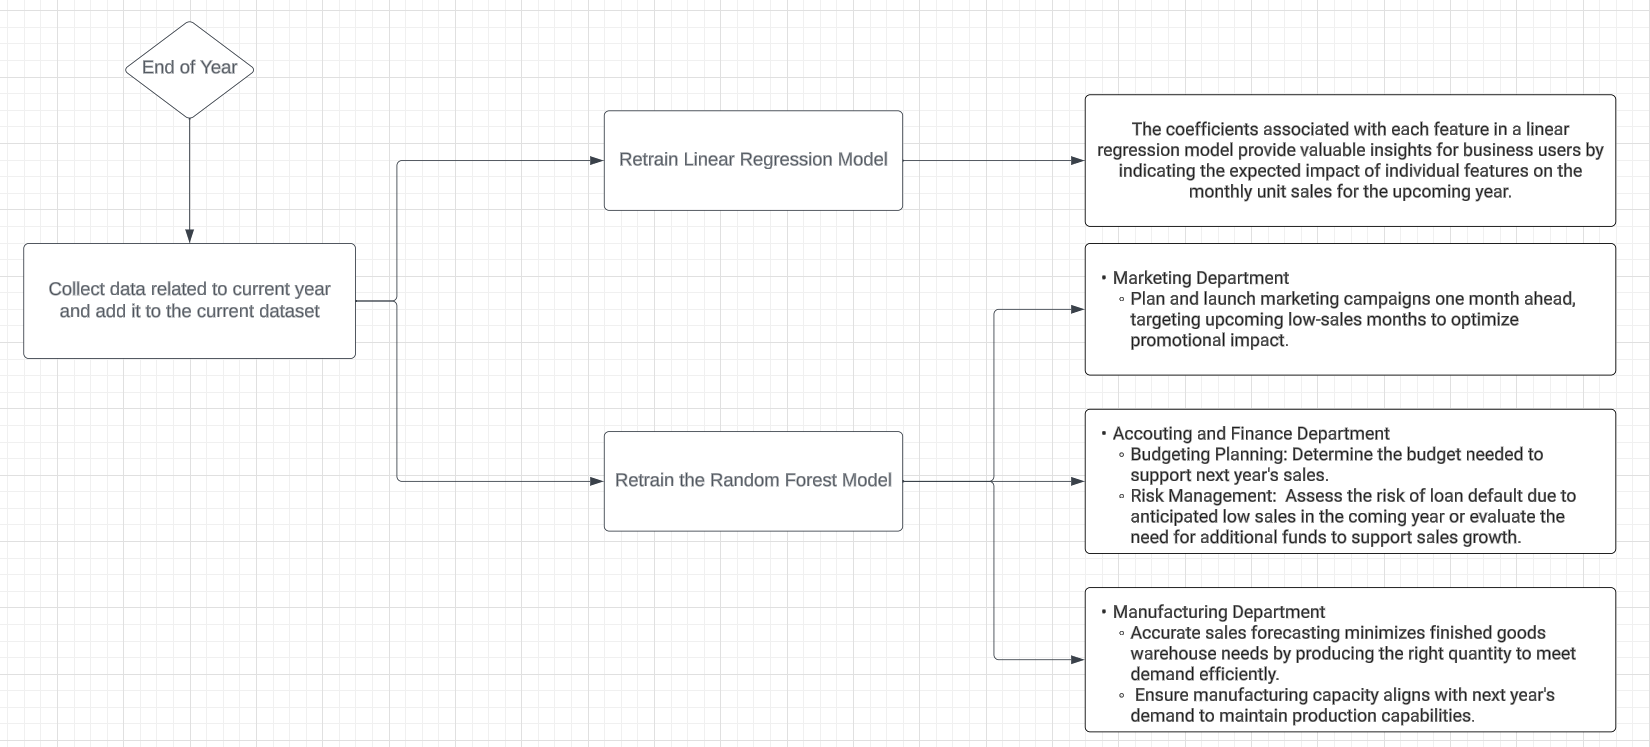

In [490]:
Image(filename="business_use_case.png")

# Section 13. Future Works
- Trying more models
    - variants of gradient boosting: HistGradientBoostingRegressor, LightGBM, CatBoost
    - SVM
    - linear regression with ridge regularization
    - linear regression with net-elastic regularization
- Trying more combinations of hyper-parameter
    - databricks: make feature store for the training dataset and use Auto-ML to automatically perform hyper-parameter tuning
- Data size if very limited
    - The data size is very limited. Thus, it is essential to retrain the model at the end of each year before it's used to make monthly prediction of the next year to ensure the realiability of the model.
- More Feature Engineering to help the model capture the non-linear relationship between features and target varaibles
- Different method for data standardization
    - Throughout the project, only standard scaler is applied to the dataset. We could also experiment different scaler:
        - Min-Max Scaler
        - Max Absolute Scaler
        - Robust Scaler
- Research for more relevant new features instead of just economic and feright variable
    - Marketing Varaibles: More efforts on marketing could lead to more sales
        - Monthly Advertisement Spending
        - Monthly Advertisement Campaign Response Rate
    - Sales Promotion: Discount can lead to more sales
        - Monthly Average Promotion Discount Rate
        - Monthly Amount of Sales Promotion
    - Product Features
        - Whether new truck is introduced during the Month
        - Whether new features are implented to the truck during the Month such as auto-driving
    - Customer Feedback and Satisfaction
        - Average Monthly Survey Sentiment Score
            - Send Survey to Users to Ask Their Experience Driving Damiler Truck
            - Apply Sentiment Analysis to get the sentiment score
        - Average Twitter Review Sentiment Score
            - Use web scrapping technique to extract monthly twitter reviews related to Damiler Truck
            - Apply Sentiment Analysis to get the sentiment score
    - Information Related to Competitors such as western star trucks and Hino
        - Market Size During that Month
        - Monthly Sales in Units